In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, MultiLineString
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np
from pyfonts import load_font

In [2]:
subtitle_font = load_font('/home/kbt28/.local/share/fonts/texgyreheros-bold.otf')
subtitle_font.set_size(10)
zone_label_font = load_font('/home/kbt28/.local/share/fonts/texgyreheros-bold.otf')
zone_label_font.set_size(8)
legend_font = load_font('/home/kbt28/.local/share/fonts/texgyreheros-regular.otf')
legend_font.set_size(9)
cbar_font = load_font('/home/kbt28/.local/share/fonts/texgyreheros-regular.otf')
cbar_font.set_size(9)

In [3]:
# load zone gdf and assign COLOR
zone_zipfile = "NYISO_Load_Zone.zip"
zones = gpd.read_file(zone_zipfile)
zones.loc[zones['ZN_ABBRV'] == 'CAPITL', 'COLOR'] = 1.0 # F
zones.loc[zones['ZN_ABBRV'] == 'CENTRL', 'COLOR'] = 1.0 # C 
zones.loc[zones['ZN_ABBRV'] == 'DUNWOD', 'COLOR'] = 1.0 # I
zones.loc[zones['ZN_ABBRV'] == 'GENESE', 'COLOR'] = 3.0 # B
zones.loc[zones['ZN_ABBRV'] == 'HUD VL', 'COLOR'] = 3.0 # G
zones.loc[zones['ZN_ABBRV'] == 'LONGIL', 'COLOR'] = 2.0 # K
zones.loc[zones['ZN_ABBRV'] == 'MILLWD', 'COLOR'] = 2.0 # H
zones.loc[zones['ZN_ABBRV'] == 'MHK VL', 'COLOR'] = 2.0 # E
zones.loc[zones['ZN_ABBRV'] == 'N.Y.C.', 'COLOR'] = 3.0 # J
zones.loc[zones['ZN_ABBRV'] == 'NORTH', 'COLOR']  = 3.0 # D
zones.loc[zones['ZN_ABBRV'] == 'WEST', 'COLOR']   = 2.0 # A

zones.set_crs(epsg=4326, inplace=True)

zones_val_to_color = {
    1.0: '#a3c6d2',
    2.0: '#c8a2c8',
    3.0: '#b5c9a5'
}
zones['COLOR'] = zones['COLOR'].map(zones_val_to_color)
zones = zones.dissolve(by="ZN_ABBRV", as_index=False);

In [4]:
# zone node gdf
zone_id = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "NE", "PJM", "IESO"]
nodes_coords = [Point([-78.5, 42.7]), # A
                Point([-77.5, 43.1]), # B
                Point([-76.8, 42.5]), # C
                Point([-74.1, 44.7]), # D
                Point([-75.3, 42.8]), # E
                Point([-73.9, 43.1]), # F
                Point([-74.0, 41.8]), # G
                Point([-73.85, 41.25]), # H
                Point([-73.8, 41.0]), # I
                Point([-73.9, 40.7]), # J
                Point([-73.0, 40.85]), # K
                Point([-72.7, 42.5]), # NE
                Point([-75.5, 40.85]), # PJM
                Point([-77.0, 44.5]), # IESO
]
nodes_df = pd.DataFrame(nodes_coords, index=zone_id, columns=['geometry'])
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry='geometry')
nodes_gdf.set_crs(epsg=4326, inplace=True);

In [5]:
# edge gdf
edges_coords = [LineString([Point([-78.5, 42.7]), Point([-77.5, 43.1])]), # A-B
                LineString([Point([-77.5, 43.1]), Point([-76.8, 42.5])]), # B-C
                LineString([Point([-76.8, 42.5]), Point([-75.3, 42.8])]), # C-E
                LineString([Point([-74.1, 44.7]), Point([-75.3, 42.8])]), # D-E
                LineString([Point([-75.3, 42.8]), Point([-73.9, 43.1])]), # E-F
                LineString([Point([-75.3, 42.8]), Point([-74.0, 41.8])]), # E-G
                LineString([Point([-73.9, 43.1]), Point([-74.0, 41.8])]), # F-G
                LineString([Point([-74.0, 41.8]), Point([-73.85, 41.25])]), # G-H
                LineString([Point([-73.85, 41.25]), Point([-73.8, 41.0])]), # H-I
                LineString([Point([-73.8, 41.0]), Point([-73.9, 40.7])]), # I-J
                LineString([Point([-73.8, 41.0]), Point([-73.0, 40.85])]), # I-K
                LineString([]), # Total East
                MultiLineString([[Point([-73.9, 43.1]), Point([-72.7, 42.5])], [Point([-72.7, 42.5]), Point([-74.0, 41.8])]]), # NY-NE (F-NE-G)
                MultiLineString([[Point([-78.5, 42.7]), Point([-77.0, 44.5])], [Point([-77.0, 44.5]), Point([-74.1, 44.7])]]), # NY-IESO (A-IESO-D)
                LineString([Point([-76.8, 42.5]), Point([-75.5, 40.85])]), # NY-PJM (C-PJM)
]
edges_df = pd.DataFrame(edges_coords, index=np.arange(1, 16, 1), columns=['geometry'])

PJM_NY_coords = [LineString([Point([-75.5, 40.85]), Point([-74.0, 41.8])]), # PJM-G
                 LineString([Point([-75.5, 40.85]), Point([-73.9, 40.7])]), # PJM-J
                 LineString([Point([-75.5, 40.85]), Point([-73.0, 40.85])]) # PJM-K
]
PJM_NY_df = pd.DataFrame(PJM_NY_coords, index=np.arange(1, 4, 1), columns=['geometry'])

# color edge according to proportion of cluster scenarios with IF flagged - 3 cluster case
if_flags_df = pd.read_csv("if_flags.csv")
if_flags_df.drop(columns=['scenario', 'yr'], inplace=True)
labels = np.loadtxt("cluster_labels_3.txt", dtype=int)
if_flags_df.insert(len(if_flags_df.columns), "label", labels)
prop_if_flags_df = if_flags_df.groupby("label").mean()
for i in [1, 2, 3]:
    edges_df[f'clus{i}_flag_prop'] = prop_if_flags_df.iloc[i-1].values
    
edges_gdf = gpd.GeoDataFrame(edges_df, geometry='geometry')
edges_gdf.set_crs(epsg=4326, inplace=True)

PJM_NY_gdf = gpd.GeoDataFrame(PJM_NY_df, geometry='geometry')
PJM_NY_gdf.set_crs(epsg=4326, inplace=True);

In [6]:
colors = [
    "#fae0e0", "#ea7d7d", "#e15151", "#d32f2f",
    "#a82828", "#7e1e1e", "#541313"
]

custom_cmap = mcolors.LinearSegmentedColormap.from_list("rust_peach", colors)

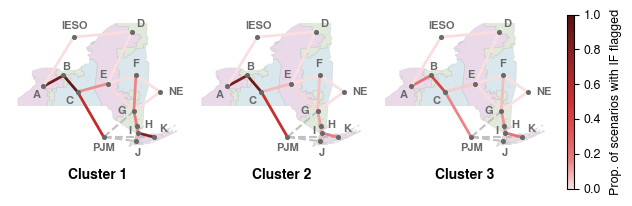

In [7]:
# plot

offsets = [(-8.0, -8.0), # A
           (-1.0, 4.0), # B
           (-9.0, -9.0), # C
           (3.0, 3.0), # D
           (-6.0, 4.0), # E
           (-3.0, 6.0), # F
           (-12.0, -2.0), # G
           (5.0, -1.0), # H
           (-7.0, -1.0), # I
           (-1.0, -11.0), # J
           (4.0, 4.0), # K
           (6.0, -2.0), # NE
           (-8.0, -10.0), # PJM
           (-9.0, 6.0) # IESO
]

fig = plt.figure(figsize=(7.0,3.0))
gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1], wspace=0.05, hspace=0.0)

axs = []
for i in range(3):
    ax = fig.add_subplot(gs[0, i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    zones.plot(ax=ax, color=zones['COLOR'], edgecolor='#c2c2c2', linewidth=0.5, zorder=1, alpha=0.4)
    edges_plt = edges_gdf.plot(column=f'clus{i+1}_flag_prop', ax=ax, cmap=custom_cmap, vmin=0.0, vmax=1.0, zorder=2, linewidth=2.0)
    PJM_NY_plt = PJM_NY_gdf.plot(ax=ax, color='silver', linestyle='dashed', zorder=1)
    nodes_plt = nodes_gdf.plot(ax=ax, markersize=7, color='dimgrey', zorder=3)
    for label, offset in zip(zone_id, offsets):
        ax.annotate(label,
                    xy=(nodes_df.loc[label]['geometry'].x, nodes_df.loc[label]['geometry'].y),
                    xycoords='data',
                    xytext=offset,
                    textcoords='offset points',
                    font=zone_label_font,
                    color='dimgrey',
                    weight='semibold'
        )
    ax.set_title(f'Cluster {i+1}', loc='center', y=-0.25, font=subtitle_font)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.58])
cbar = fig.colorbar(mappable=None, cmap=custom_cmap, cax=cbar_ax, orientation='vertical')
cbar_ax.tick_params(labelsize=8.0)
for label in cbar_ax.get_yticklabels():
    label.set_fontproperties(cbar_font)
cbar.set_label('Prop. of scenarios with IF flagged', loc='center', font=legend_font, labelpad=7)

plt.savefig(f"map_3_clusters.png", dpi=300, bbox_inches='tight')

In [8]:
# color edge according to proportion of cluster scenarios with IF flagged - 8 cluster case
labels = np.loadtxt("cluster_labels_8.txt", dtype=int)
if_flags_df['label'] = labels
prop_if_flags_df = if_flags_df.groupby("label").mean()
for i in range(1,9):
    edges_df[f'clus{i}_flag_prop'] = prop_if_flags_df.iloc[i-1].values
    
edges_gdf = gpd.GeoDataFrame(edges_df, geometry='geometry')
edges_gdf.set_crs(epsg=4326, inplace=True)

,geometry,clus1_flag_prop,clus2_flag_prop,clus3_flag_prop,clus4_flag_prop,clus5_flag_prop,clus6_flag_prop,clus7_flag_prop,clus8_flag_prop
1,"LINESTRING (-78.5 42.7, -77.5 43.1)",0.834615,0.953250,0.374233,0.171750,0.809836,0.915323,0.077132,0.8008
2,"LINESTRING (-77.5 43.1, -76.8 42.5)",0.924038,0.945268,0.306748,0.792937,0.845902,0.829839,0.189655,0.8912
3,"LINESTRING (-76.8 42.5, -75.3 42.8)",0.135577,0.058153,0.208589,0.022472,0.380328,0.041935,0.029946,0.0688
4,"LINESTRING (-74.1 44.7, -75.3 42.8)",0.001923,0.001140,0.000000,0.000000,0.000000,0.000000,0.000000,0.0016
5,"LINESTRING (-75.3 42.8, -73.9 43.1)",0.004808,0.002281,0.024540,0.000000,0.013115,0.004839,0.003630,0.0040
6,"LINESTRING (-75.3 42.8, -74 41.8)",0.015385,0.012543,0.006135,0.009631,0.016393,0.008871,0.007260,0.0200
7,"LINESTRING (-73.9 43.1, -74 41.8)",0.133654,0.092360,0.214724,0.046549,0.409836,0.034677,0.054446,0.0480
8,"LINESTRING (-74 41.8, -73.85 41.25)",0.107692,0.084379,0.840491,0.113965,0.878689,0.059677,0.058984,0.0824
9,"LINESTRING (-73.85 41.25, -73.8 41)",0.059615,0.072976,0.809816,0.086677,0.878689,0.062903,0.083485,0.0600
10,"LINESTRING (-73.8 41, -73.9 40.7)",0.068269,0.085519,0.104294,0.022472,0.118033,0.051613,0.019964,0.0600


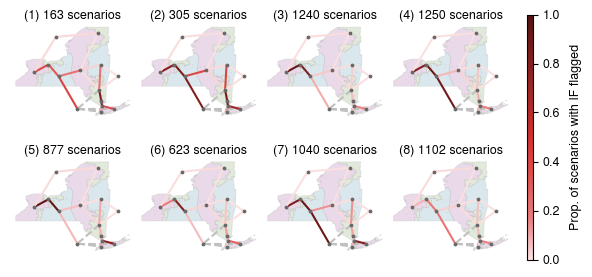

In [9]:
# plot
clus_order = [3, 5, 6, 8, 2, 4, 1, 7]
clus_size = [np.sum(labels == i) for i in clus_order]

fig = plt.figure(figsize=(6.5,3.5))
gs = gridspec.GridSpec(2, 4, width_ratios=[1,1,1,1], wspace=0.0, hspace=0.0)

axs = []
ct = 0
for row in range(2):
    for col in range(4):
        ax = fig.add_subplot(gs[row, col])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        ax.set_title(f'({ct+1}) {clus_size[ct]} scenarios', loc='center', y=0.95, font=legend_font)
        zones_plt = zones.plot(ax=ax, color=zones['COLOR'], edgecolor='#c2c2c2', linewidth=0.5, zorder=1, alpha=0.4)
        edges_plt = edges_gdf.plot(column=f'clus{clus_order[ct]}_flag_prop', ax=ax, cmap=custom_cmap, vmin=0.0, vmax=1.0, zorder=2, linewidth=1.5)
        PJM_NY_plt = PJM_NY_gdf.plot(ax=ax, color='silver', linestyle='dashed', zorder=1)
        nodes_plt = nodes_gdf.plot(ax=ax, markersize=3, color='dimgrey', zorder=3)
        ct += 1
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
cbar = fig.colorbar(mappable=None, cmap=custom_cmap, cax=cbar_ax, orientation='vertical')
cbar_ax.tick_params(labelsize=8.0)
for label in cbar_ax.get_yticklabels():
    label.set_fontproperties(cbar_font)
cbar.set_label('Prop. of scenarios with IF flagged', loc='center', font=legend_font, labelpad=7)
plt.savefig(f"map_8_clusters.png", dpi=300, bbox_inches='tight')